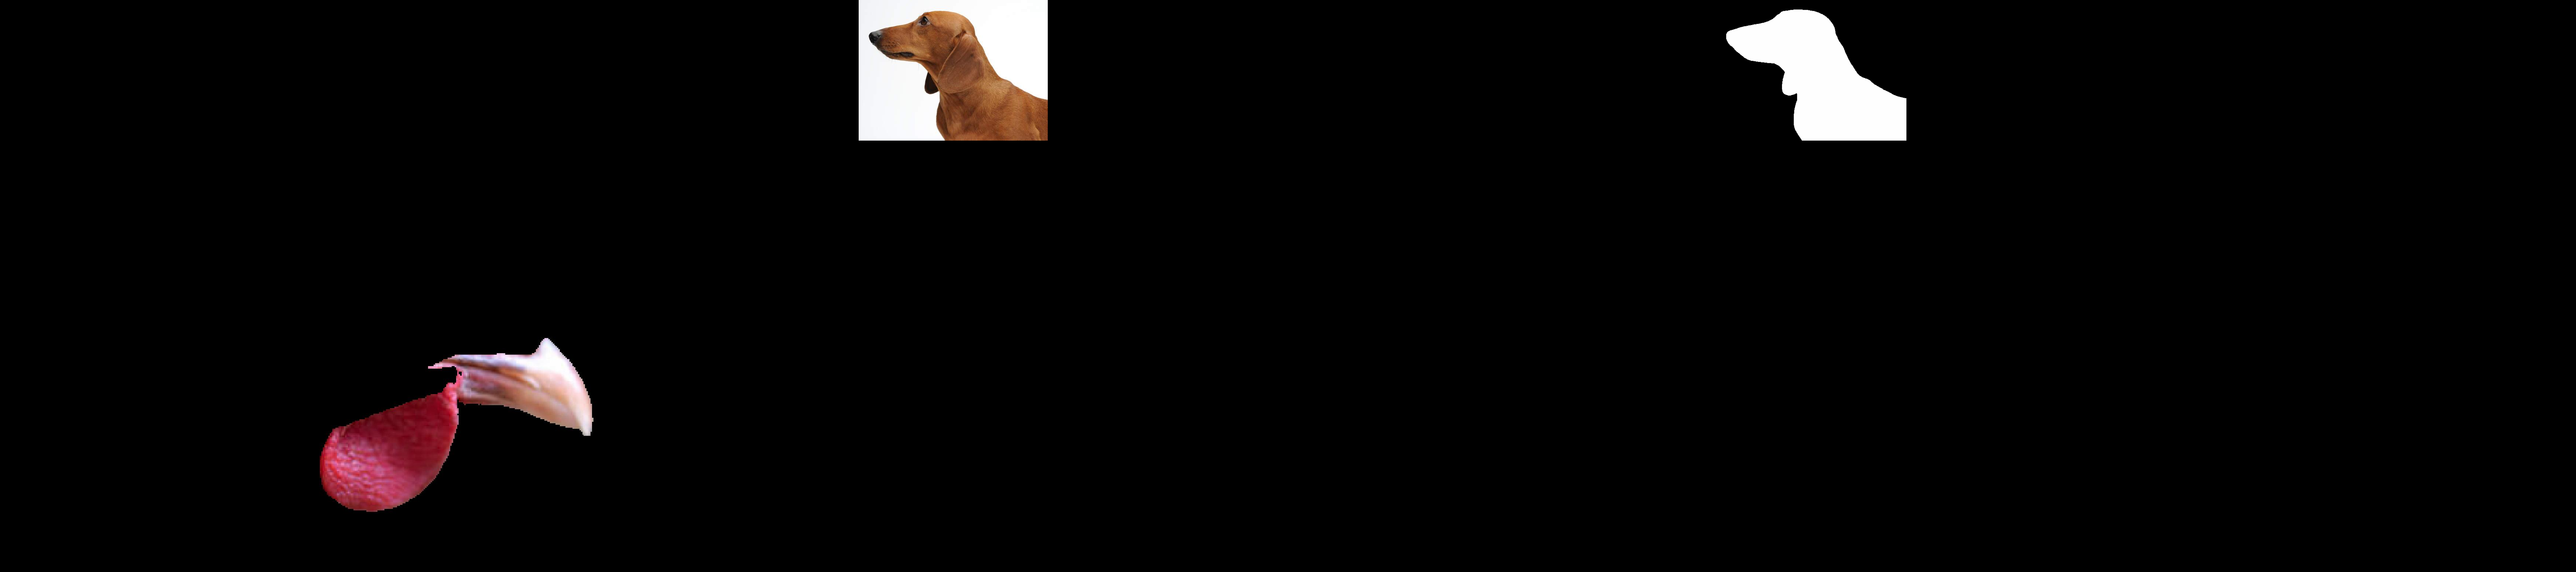

In [1]:
from PIL import Image

image = Image.open("outputs/source_foreground.jpg")
masked_image = Image.open("outputs/destination_raw_image.jpg")
w = masked_image.width
h = masked_image.height
masked_image = masked_image
mask = Image.open("outputs/destination_foreground_mask.jpg").resize((w, h))

additional_prompt_positive = "dog head with chicken beak, dog ears, dog eyes"
additional_prompt_negative = "dog snout"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid([image, masked_image, mask], 1, 3)

In [2]:
from diffusers import StableDiffusionInpaintPipeline
from diffusers import AutoencoderKL
from ipadapter.ip_adapter import IPAdapter

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    vae=AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema"),
    feature_extractor=None,
    safety_checker=None
).to("cpu")

img_encoder_path = "ipadapter/models/image_encoder/"
ip_cpkt = "ipadapter/models/ip-adapter_sd15_light.bin"
ip_model = IPAdapter(pipe, img_encoder_path, ip_cpkt, "cpu")


/home/arel/.local/share/virtualenvs/Grounded-Segment-Anything-RbStg18O/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arel/.local/share/virtualenvs/Grounded-Segment-Anything-RbStg18O/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
text_encoder/model.safetensors not found
Loading pipeline components...: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of th

Warning!! Instantiating modified IPAdapter (float16 -> bfloat16)


generating!


100%|██████████| 37/37 [03:12<00:00,  5.20s/it]


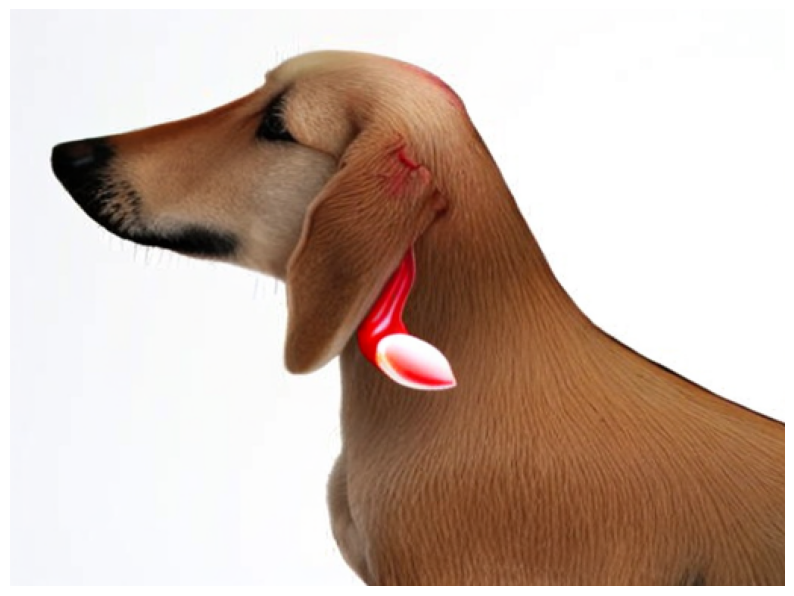

In [3]:
import os
from matplotlib import pyplot as plt


images = ip_model.generate(
    pil_image=image,
    num_samples=1,
    num_inference_steps=50,
    seed=42,
    image=masked_image,
    mask_image=mask,
    strength=0.75,
    prompt=f"{additional_prompt_positive}, photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
    negative_prompt=f"{additional_prompt_negative}, ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings",
    width=512, height=512
)

images[0] = images[0].resize((masked_image.width, masked_image.height))

for idx, image in enumerate(images):
    image = image.resize((masked_image.width, masked_image.height))
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(os.path.join("outputs", f'final_{idx}.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)